# Generating synthetic data for clustering

### Authors: Cindy Tan and Dhananjay Bhaskar

We empirically compare the performance of various clustering methods. Clustering in low dimensions (2-D or 3-D) is typically performed after dimensionality reduction. K-Means, DBSCAN, Voronoi or graph-based algorithms require parameters that are difficult to estimate given arbitrary data. We will demonstrate how known heuristics for parameter estimation fail for challenging synthetic data.

We will implemented unsupervised methods that do not require any parameters, e.g. X-Means, OPTICS, non-parametric mixture model (NMM), etc. and evaluate their performance on synthetic data. To ascertain whether poor clustering result can be detected and resolved for arbitrary data, we will implement and test various cluster validity indices. We will also investigate robustness of clustering methods to initial condition, noise, cluster density and overlap. 

High-dimensional data exhibits "curse of dimensionality" i.e. distances between all pairs of points converges to the same value. Therefore, clustering methods that rely on computation of some distance metric fail to perform well. Two approaches exist: projected clustering (see: http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.467.9666&rep=rep1&type=pdf) and subspace clustering (see: http://www.kdd.org/exploration_files/parsons.pdf). Another technique, namely topological data analysis, is gaining traction, but it is computationally expensive and has not seen much practical application yet.

#### TODO:

- Add comments for all code
- Document interesting examples where clustering fails or computation of parameters is incorrect
- Improve color scheme using seaborn
- Performance enhancement using numba

Shortcuts:
https://www.cheatography.com/weidadeyue/cheat-sheets/jupyter-notebook/

In [1]:
import math
import numba as nb
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from __future__ import division
from matplotlib import colors
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score

%matplotlib inline

sns.set_style("whitegrid")

## Part I: Synthetic Data Generation
Synthetic datasets of varying levels of complexity will be generated to be used to evaluate the performance of clustering algorithms.

- General Parameters
- Helper Functions
- Sample Datasets

### General Parameters
#### `dataset`
A shape `[2,n]` `np.array` representing `n` 2d points: `data[0]` and `data[1]` are `n` length arrays with the x and y components of each point. General parameter `data`.
#### `number`
Number of points in a dataset (tester `n`)
#### `density`
Number of points per unit area for uniform distributions, affects standard deviation for normal distributions (tester `d`)
#### `ratio`
Shape ratio width / height

### Helper functions

In [8]:
"""
Tester Constants
    standardized units for number (n) and density (d) for easy testing access 
"""
n = 100
d = 50

"""
Plotting functions
    plot - plots a standard graph of the dataset with a title
    test - plots a standard graph without a title (used for quick test graphs)
"""
def plot(data, setid):
    plt.scatter(data[0], data[1], 2)
    plt.title(setid)
    plt.axis('off')
    plt.show()
    
def test(data):
    plt.scatter(data[0], data[1], 2)
    plt.axis('equal')
    plt.show()

"""
combine(*sets)
    Combines data sets
    *sets - datasets to combine
    Returns single np.array representing points of combined dataset
"""
def combine(*sets):
    data = np.zeros([2,0])
    for i in sets:
        data = np.stack((np.concatenate((data[0], i[0])),
                         np.concatenate((data[1], i[1]))))
    return data

"""
Shape Functions

square(number, density)
    Uniform distribution, square shape
    
circle(number, density, angle, hollow)
    Uniform distribution, circular shape
    angle - 0 to 2pi, slice angle in radians (default 2pi for full circle)
    hollow - 0 to 1, fraction of circle that is hollow to construct rings (default is 0 for solid circle)
    
normal(number, density)
    Normal distribution (in both x and y)

normalstrip(number, density)
    Returns normal
"""
def square(number, density):
    half = math.sqrt(number / (4 * density))
    return np.random.uniform(-half, half, (2, number))

def circle(number, density, angle = 2 * math.pi, hollow = 0):
    radius = math.sqrt(number / (density * math.pi * (1 - hollow**2)))
    angles = np.random.uniform(0, angle, number)
    radii = np.random.uniform((hollow * radius)**2, radius**2, number)
    cartesian = np.zeros([2, number])
    for i in range(0,number):
        cartesian[0,i] = math.sqrt(radii[i]) * math.cos(angles[i])
        cartesian[1,i] = math.sqrt(radii[i]) * math.sin(angles[i])     
    return cartesian

def normal(number, density):
    stdev = math.sqrt(number / (2 * density * math.pi))
    return np.random.normal(0, stdev**2, (2,number))

def normalstrip(number, density):
    stdev = math.sqrt(number / (2 * density * math.pi))
    half = math.sqrt(number / (4 * density))
    return np.stack((np.random.normal(0, stdev**2, number), np.random.uniform(-half, half, number)))


"""
Standard Linear Transformation Matrices

linear(data, tmx)
    Applies linear transformation to dataset
    tmx - 3,3 np.matrix transformation matrix
    Returns 2,n np.array representing n 2d points from data after transformation
    
rotate(data, angle)
    angle - standard counterclockwise angle from positive x-axis to rotate by

dilate(data, ratio) - maintains density, adjusts shape
    ratio - width / height ratio to dilate using

scale(data, factor) - adjusts density, maintains shape
    factor - number to multiply all dimensions by

pos(data, x, y) - translation
    x, y - numbers to translate dataset along x and y axes
    
skew(data, x, y) - skew
    x, y - numbers to skew along x and y axes
"""
def linear(data, tmx):
    res = np.zeros([2, data.shape[1]])
    for i in range(0, data.shape[1]):
        omx = tmx * np.matrix([[data[0,i],],[data[1,i],],[1,]])
        res[0,i] = omx[0,0]
        res[1,i] = omx[1,0]
    return res

def rotate(data, angle):
    rmx = np.matrix([[math.cos(angle),-math.sin(angle),0],
                     [math.sin(angle),math.cos(angle),0],
                     [0,0,1]])
    return linear(data, rmx)

def dilate(data, ratio):
    dmx = np.matrix([[math.sqrt(ratio),0,0],
                     [0,1/math.sqrt(ratio),0],
                     [0,0,1]])
    return linear(data, dmx)

def scale(data, factor):
    smx = np.matrix([[factor,0,0],
                     [0,factor,0],
                     [0,0,1]])
    return linear(data, smx)
    
def pos(data, x, y):
    rmx = np.matrix([[1,0,x],
                     [0,1,y],
                     [0,0,1]])
    return linear(data, rmx)

def skew(data, x, y):
    smx = np.matrix([[1,x,0],
                     [y,1,0],
                     [0,0,1]])
    return linear(data, smx)

"""
cut(data, cover, cutshape, *cuts)
    Cuts portions of an existing dataset (effectively redistributes invalid points, thus maintaining number and
    increasing density)
    cover - a dataset similar in shape and distribution to data but distinctly generated
        if no cover dataset, enter [] as cover argument: data will be assumed to be rotationally symmetrical and a
        cover will be generated by rotating data by pi radians
    cutshape - 'circles' or 'slices', determines how *cuts arguments are interpreted
    *cuts (multiple arguments for multiple cuts)
        'circles': [[centrepoint_x, centrepoint_y], radius] - a circular hole cut with given centrepoint (default
        is [0, 0] and radius
        'slices': [line, mode] - a slice cut of all points on one side of a straight horizontal or vertical line
            line - cutoff value
            mode - 0, 1, 2, 3 = above, below, right, left
        'roundcut': [radius, direction, [origin_x, origin_y], angle] - a slice cut of all points on one side of a
        semicircular arc
            radius - radius of cut arc, larger radius indicates lower curvature
            direction - 1 for the circular 'inside', 0 for 'outside'
            origin - coordinates of centre of slice (default is [0, 0] for no translation)
            angle - 0 to 2pi, counterclockwise radian angle of slice centreline (default is 0 for no rotation)
    checkindices(indices)
        Checks data points in data to see which points satisfy a condition (and are invalid)
        indices - array of indices to check in data
        Returns an array of indices (subset of input indices) corresponding to invalid points
"""
def cut(data, cover, cutshape, *cuts):
    ds = data # Creates copy of data to work with
    if len(cover) == 0:
        cover = rotate(ds, math.pi)
    def checkindices(indices):
        invalid = []
        for i in indices: # For each point
            point = np.array([ds[0,i],ds[1,i]])
            for cut in cuts: # Check condition for each cut
                # According to the shape of the cuts, check if the point is invalid
                if cutshape == 'circles':
                    try: # Assume centrepoint and radius are provided
                        centrepoint = cut[0]
                        radius = cut[1]
                    except IndexError: # If only one argument is provided, it is radius
                        centrepoint = [0, 0]
                        radius = cut[0]
                    distance = math.sqrt((centrepoint[0] - point[0])**2 + (centrepoint[1] - point[1])**2)
                    if distance < radius:
                        invalid.append(i)
                elif cutshape == 'slices':
                    line = cut[0]
                    mode = cut[1]
                    if (mode == 0 and point[1] > line) or (mode == 1 and point[1] < line) \
                    or (mode == 2 and point[0] > line) or (mode == 3 and point[0] < line):
                        invalid.append(i)
                elif cutshape == 'roundcut':
                    radius = cut[0]
                    direction = cut[1]
                    # Assignment of optional arguments
                    try: # Assume origin and angle are provided
                        origin = cut[2]
                        angle = cut[3]
                    except IndexError: # If one or none of the origin and angle are provided, then IndexError triggers
                        try: # Assume only angle is provided
                            origin = [0, 0]
                            angle = float(cut[2])
                        except TypeError: # If the third argument is not a number, TypeError triggers
                            origin = cut[2]
                            angle = 0
                        except IndexError: # If neither argument is provided, IndexError triggers
                            origin = [0, 0]
                            angle = 0
                    point = rotate(pos(point.reshape((2, 1)), -origin[0], -origin[1]), -angle).flatten()
                    if (abs(point[1]) > radius or point[0] <= radius - math.sqrt(radius**2 - point[1]**2)) == direction:
                        invalid.append(i)
                    point = np.array([ds[0,i],ds[1,i]])
        return invalid
    indices = checkindices(range(ds.shape[1])) # Check all points in data (ds)
    while indices != []:
        # Generate an array of indices corresponding to random points in cover dataset
        coverindices = np.random.randint(cover.shape[1], size = len(indices))
        # Replace all invalid data points with points from cover dataset
        for i in range(len(indices)):
            ds[0,indices[i]], ds[1,indices[i]] = cover[0, coverindices[i]], cover[1, coverindices[i]]
        # Delete used points from cover to avoid reuse
        cover = np.stack((np.delete(ds[0], coverindices), np.delete(ds[1], coverindices)))
        # Check all replaced indices to see if any invalid values remain until there are no more invalid values
        indices = checkindices(indices)
    return ds

"""
urcshape(number, density, hollow, ratio, shape)
    Uniform rectangular composition shape
    hollow - 0 to 1, fraction of centre or corners that are hollowed out, relative to width
    shape - 'frame' or 'cross'
"""
def urcshape(number, density, hollow, ratio, shape, distribution = 'uniform'):
    x = math.sqrt(number / (density * (1 - hollow) * ((1 / ratio) + hollow))) # Width of shape
    y = x / ratio # Height
    width = (1 - hollow) * x / 2 # Width of bars
    size = max(x, y) # Rough general area to generate random numbers
    data = np.zeros([2, number]) # Empty array to be filled with data
    for i in range(number): 
        valid = 0 # Tracker variable to iterate loop until valid value is found
        while not(valid):
            # Randomly generate an x and y value within general area
            if distribution == 'uniform':
                xval, yval = (np.random.uniform() - 0.5) * size, (np.random.uniform() - 0.5) * size
            elif distribution == 'normal':
                xval, yval = np.random.normal() * size / 5, np.random.normal() * size / 5
            # According to the shape to be generated, find the condition the point must satisfy to be valid
            if shape == 'frame':
                cond = abs(xval) < (x / 2) and abs(yval) < (y / 2) and (abs(xval) > (x / 2) - width \
                                                                        or abs(yval) > (y / 2) - width)
            elif shape == 'cross':
                cond = abs(xval) < (x / 2) and abs(yval) < (y / 2) and (abs(xval) < width or abs(yval) < width)
            # If the point valid, the while loop breaks; if it is not valid, iterate loop to generate new random values
            if cond:
                valid = 1
        data[0,i], data[1,i] = xval, yval
    return data

### Sample Datasets
For each level, six sample datasets were generated with a 2-digit code. The first digit corresponds to the level of cluster complexity, and the second is a feature number:

Number of Clusters | 3 | 5 | 7
--- | --- | --- | ---
**No noise** | 1 | 2 | 3 
**Noise** | 4 | 5 | 6

#### Level 1
Simple, well-formed, circular or square clusters.

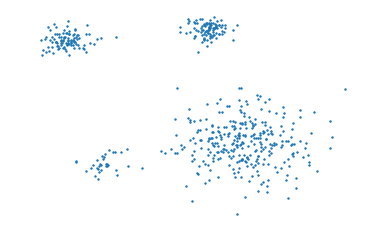

In [9]:
set11 = combine(pos(circle(n, d / 1.5, 2 * math.pi, 0),          3,  -2),
                pos(square(n, d),                               -3,   0),
                pos(normal(n, d),                                0,   2))

set12 = combine(pos(rotate(set11, 1),                           -2,   0),
                pos(normal(n, 2 * d),                            0,  -1.5),
                pos(square(n, 4 * d),                            4,  -2))

set13 = combine(pos(rotate(square(n, d / 2), math.pi / 3),       4,  -1),
                pos(square(n, d * 3),                            0,   0),
                pos(circle(n, d),                                3,   3),
                pos(normal(n, d),                               -1,   2.5),
                pos(normal(n, 2 * d),                           -2,  -2),
                pos(circle(n, d * 9),                            1,  -3),
                pos(rotate(square(n, d), 5 * math.pi / 4),      -4,   0))

set00 = combine(pos(normal(n * 3, d),                            4,  -2),
                pos(normal(int(n / 3), int(d / 3)),              0,  -3),
                pos(normal(n, d),                                3,   3),
                pos(normal(n, d),                               -1,   2.5))
                                                                 #    #
# plot(set11, 'Level 1, 3 clusters')
# plot(set12, 'Level 1, 5 clusters')
# plot(set13, 'Level 1, 7 clusters')
plot(set00, '')

#### Level 2
Long, thin clusters.

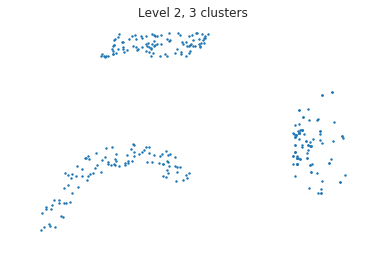

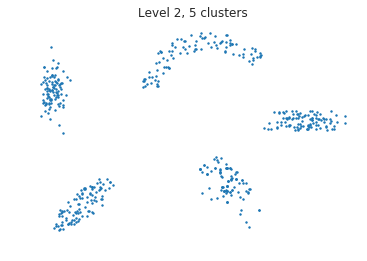

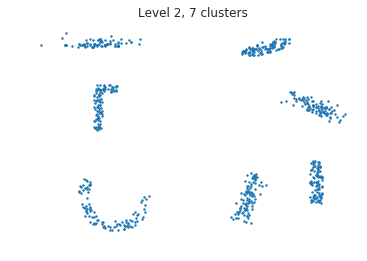

In [10]:
set21 = combine(pos(scale(cut(normal(n, d), [], 'roundcut', [2, 1]), 2),                                     3,   0),        
                pos(skew(dilate(square(n, d), 4), 1, 0),                                                    -1,   3),
                pos(scale(rotate(dilate(circle(n, d, 7 * math.pi / 8, 0.7), 1.2), math.pi / 6), 2),    -2,  -2))

set22 = combine(pos(dilate(normal(n, d), 0.4),                                                              -4,   2),
                pos(rotate(dilate(circle(n, d), 3), math.pi / 4),                                           -3,  -2),
                pos(scale(rotate(circle(n, d, 7 * math.pi / 9, 0.7), math.pi / 5), 2),                  1,   2),
                pos(dilate(normalstrip(n, d), 4),                                                       4,   1),
                pos(rotate(scale(cut(normal(n, d), [], 'roundcut', [4, 1]), 2), 6 * math.pi / 5),            2,  -1))

set23 = combine(pos(rotate(dilate(scale(cut(normal(n, d), [], 'roundcut', [4, 1]), 2), 0.3), math.pi / 2),  -6,   5),
                pos(dilate(square(int(3 * n / 4), d), 1.0 / 6),                                             -6,   1),
                pos(dilate(square(int(n / 4), d), 2),                                                       -5.25, 2.25),
                pos(scale(rotate(circle(n, d, 11 * math.pi / 9, 0.7), 4 * math.pi / 5), 2),                 -5,  -5),
                pos(rotate(scale(dilate(normalstrip(n, d), 0.4), 1.5), -math.pi / 12),                       3,  -5),
                pos(rotate(dilate(circle(n, d), 4), math.pi / 12),                                           4,   5),
                pos(scale(rotate(dilate(normal(n, d), 3), -math.pi / 7), 1.5),                               7,   1),
                pos(dilate(square(n, d), 0.25),                                                              7,  -4))
                                                                                                             #    #
plot(set21, 'Level 2, 3 clusters')
plot(set22, 'Level 2, 5 clusters')
plot(set23, 'Level 2, 7 clusters')

#### Level 3
Well-formed complex clusters.

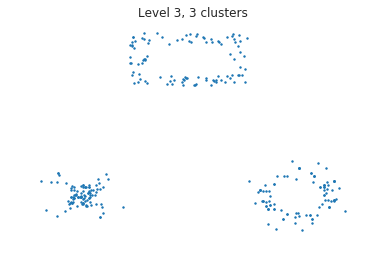

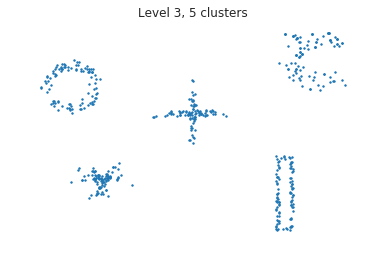

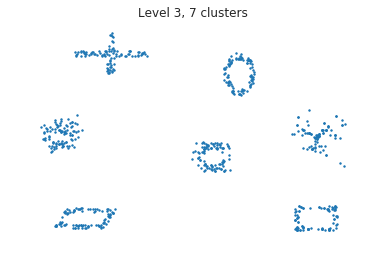

In [12]:
set31 = combine(pos(urcshape(n, d, 0.7, 1.4, 'frame'),                                                  0,   3),
                pos(scale(cut(normal(n, d), [], 'circles', [0.4]), 1.2),                                2,  -1),
                pos(cut(normal(n, d), normal(n, 1.5 * d), 'roundcut', 
                        [0.3, 0, [0.3, 0]],
                        [0.3, 0, [-0.3, 0], math.pi],
                        [0.3, 0, [0, 0.3], math.pi / 2],
                        [0.3, 0, [0, -0.3], -math.pi / 2]),                                            -2,  -1))

set32 = combine(pos(circle(n, d, hollow = 0.6),                                                        -4,   2),
                pos(scale(urcshape(n, d * 1.8, 0.6, 0.2, 'frame'), 0.8),                                3,  -2),
                pos(urcshape(n, d * 1.5, 0.9, 1, 'cross', 'normal'),                                    0,   1),
                pos(cut(normal(n, d), normal(n, 1.5 * d), 'roundcut',
                        [0.25, 0, [0, 0.2], math.pi / 2],
                        [0.25, 0, [0.1 * math.sqrt(3), -0.1], -math.pi / 6],
                        [0.25, 0, [-0.1 * math.sqrt(3), -0.1], 7 * math.pi / 6]),                      -3,  -1.5),
                pos(scale(cut(normal(n, d), [], 'roundcut', [0.3, 0, [-0.3, 0]]), 1.5),                 4,   3))

set33 = combine(pos(scale(cut(normal(n, d), [], 'circles', [0.15]), 1.2),                              -5,   0),
                pos(urcshape(n, d * 1.5, 0.9, 1.4, 'cross'),                                           -3,   4),
                pos(skew(scale(urcshape(n, d * 2, 0.8, 2, 'frame'), 1), 0.5, 0),                       -4,  -4),
                pos(dilate(circle(n, d * 2, hollow = 0.7), 0.6),                                        2,   3),
                pos(cut(normal(n, 2 * d / 3), normal(n, 1.5 * d), 'roundcut',
                        [0.25, 0, [0, 0.1], math.pi / 2],
                        [0.25, 0, [0.05 * math.sqrt(3), -0.05], -math.pi / 6],
                        [0.25, 0, [-0.05 * math.sqrt(3), -0.05], 7 * math.pi / 6]),                     5,   0),
                pos(cut(normalstrip(n, d), [], 'circles', [0.4]),                                       1,  -1),
                pos(dilate(cut(square(n, d), [], 'circles', [0.6]), 1.4),                               5,  -4))
                                                                                                        #    #
plot(set31, 'Level 3, 3 clusters')
plot(set32, 'Level 3, 5 clusters')
plot(set33, 'Level 3, 7 clusters')

np.savetxt("Practice2DTDA_35.csv", set32, delimiter=",")

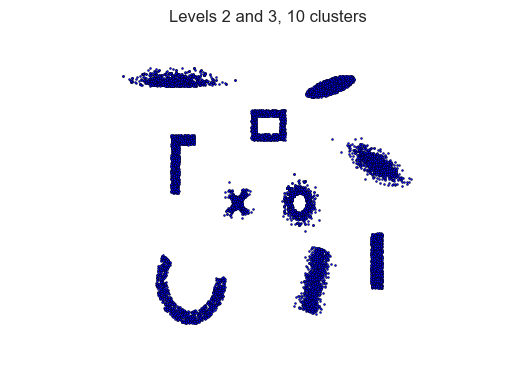

In [6]:
plot(combine(set31, set23), 'Levels 2 and 3, 10 clusters')

#### Level 4
Bridged and holed structures, and complex letter shapes.

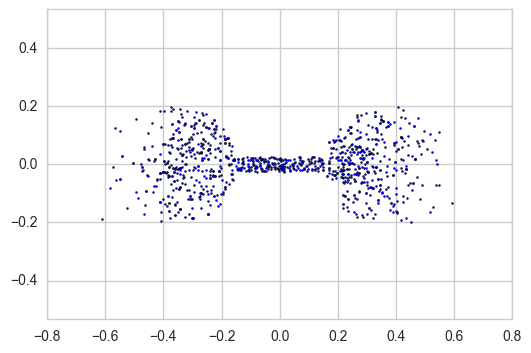

In [7]:
set41 = combine(pos(cut(normal(int(2 * n / 5), d), [], 'roundcut', [0.2, 1, [-0.1, 0]]),                0.25, 0),
                pos(cut(normal(int(2 * n / 5), d), [], 'roundcut', [0.2, 1, [0.1, 0], math.pi]),       -0.25, 0),
                pos(dilate(square(int(n / 5), 120.0 * n / 9), 6),                                       0,  0))
                                                                                                        #    #
test(set41)

#### Level 5
Nested and irregular paired clusters (each cluster has two subclusters of `n` points).

In [8]:
set51 = combine(
                pos(dilate(combine(pos(cut(circle(2 * n, d, hollow = 0.6), [], 'slices', [0.6, 2]), -0.1, 0.4),
                           pos(cut(circle(2 * n, d * 4 / 3, hollow = 0.7), [], 'slices', [-0.6, 3]), 0.1, -0.4)), 0.8),
                                                                                                       1, -1),
                
                )

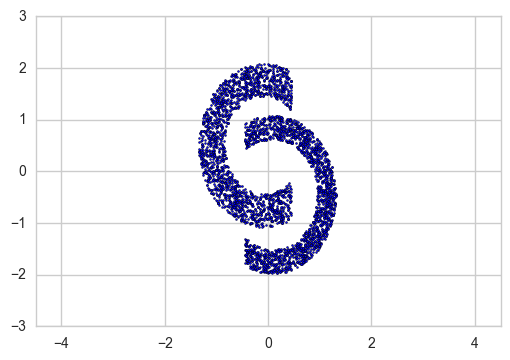

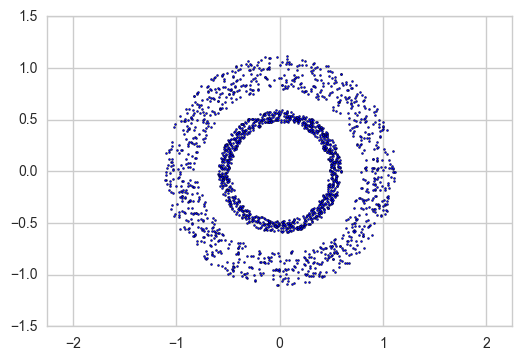

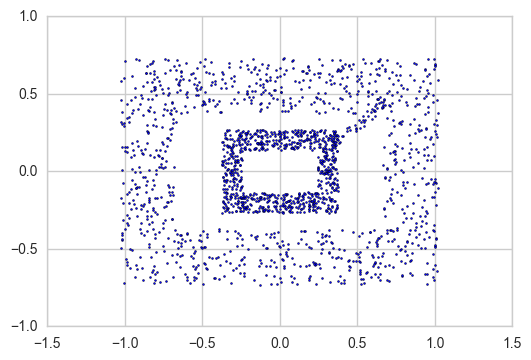

In [9]:
t1 = dilate(combine(pos(cut(circle(2 * n, d, hollow = 0.6), [], 'slices', [0.6, 2]), -0.1, 0.45),
                    pos(cut(circle(2 * n, d * 4 / 3, hollow = 0.7), [], 'slices', [-0.6, 3]), 0.1, -0.4)), 0.8)
t2 = combine(circle(n, d , 2 * math.pi, 0.7), circle(n, 5 * d, 2 * math.pi, 0.8))
t3 = combine(urcshape(n, d, 0.65, 1.4, 'frame'),
             urcshape(int(4 * n / 5), d * 6, 0.65, 1.4, 'frame'),
             pos(scale(skew(dilate(square(int(n / 20), d), 4), 0, 0.8), 0.55), 0.5, 0.3))

test(t1)
test(t2)
test(t3)

## Part II: K-Means Clustering

There are four methods to find the optimal numbers of clusters in an arbitrary data set: Elbow method, Bayesian Information Criterion (used in X-Means), Silhouette Analysis (based on silhouette score, a cluster validity index) and Gap statistic.

These methods (excluding BIC) are described in:

http://www.sthda.com/english/wiki/determining-the-optimal-number-of-clusters-3-must-known-methods-unsupervised-machine-learning#three-popular-methods-for-determining-the-optimal-number-of-clusters
- Elbow Method
- Gap Statistic
- Silhouette Analysis

**TODO:**
- Implement BIC (See: http://stats.stackexchange.com/questions/90769/using-bic-to-estimate-the-number-of-k-in-kmeans)

In [10]:
clist = ['b','g','r','c','m','gold','teal','brown']

def transpose(data):
    tr = np.zeros([data.shape[1], data.shape[0]])
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            tr[j,i] = data[i,j]
    return tr

def colplt(data, labels, setid):
    num_classes = len(np.unique(labels))
    clist_truncated = clist[0:num_classes]
    
    custom_map = dict(zip(np.unique(labels), clist_truncated))
    pt_clrs = []
    for label in labels:
        pt_clrs.append(custom_map[label])
    
    for i in range(len(data[0])):
        plt.scatter(data[0][i], data[1][i], color=pt_clrs[i], s=5, edgecolors='none')
    plt.title(setid)
    plt.axis('equal')
    plt.show()

### Elbow Method
- TODO: Implemement perpendicular distance from line heuristic
- TODO: Plot perpendicular distance vs. K
- TODO: Calculate curvature of each point 

In [11]:
"""
sqd(a, b):
Squared distance between two vectors
    a, b - two vector tuples of the same dimension.
"""
def sqd(a, b):
    if len(a) != len(b):
        return None
    sqd = sum((a[i] - b[i])**2 for i in range(len(a)))
    return sqd

"""
ss(data, k)
Sum of squared distances for the k-means clustering of data using k.
    k - integer representing how many clusters the k-means algorithm should search for.
"""
def ss(data, k):
    km = KMeans(n_clusters=k).fit(transpose(data))
    ss = sum(sqd([data[0,i],data[1,i]], km.cluster_centers_[km.labels_[i]]) for i in range(data.shape[1]))
    return ss

def elbow(data):
    max_k = 10
    variances = np.stack((np.arange(max_k),np.zeros(max_k)))
    for i in range(max_k):
        variances[0,i] += 1
        variances[1,i] = ss(data, int(variances[0,i])) / data.shape[1]
    plt.plot(variances[0], variances[1], '-o')
    plt.show()
    return variances

### Gap Statistic

The gap statistic builds upon the ideas of the basic elbow method often used with $k$-means to create a more concrete way of identifying the optimal $k$. Like the elbow method, it uses the variance of each clustering as its basis metric. The gap statistic compares the variance of each $k$ to the variance of randomly generated uniform distribution control sets that have been clustered with the same $k$, and uses the natural logarithm to make the elbow more prominent. The final $k$ is given by an indicator expression. The implementation of this heuristic showed promising results in the shapes of the graphs (very prominent elbows) but the indicator expression often failed to identify the elbow. Thus, in a modification of the gap statistic implemented below, the indicator expression was replaced with a simple difference equation which consistently gave correct results with very prominent peaks.

The below is a table comparing the results of the original gap statistic and the modified heuristic:

Set | Clusters | Gap | Modified Gap
--- | --- | --- | ---
11 | 3 | 3 | 3
12 | 5 | 5 | 5
13 | 7 | **1** | 7
21 | 3 | **No K Found** | 3
22 | 5 | **No K Found** | 5
23 | 7 | **8 or 9** | 7
31 | 3 | 3 | 3
32 | 5 | **No K Found** | 5
33 | 7 | 7 | 7

**TODO:**
- Description in your own words [DONE]

Reference: https://datasciencelab.wordpress.com/2013/12/27/finding-the-k-in-k-means-clustering/

k = 8


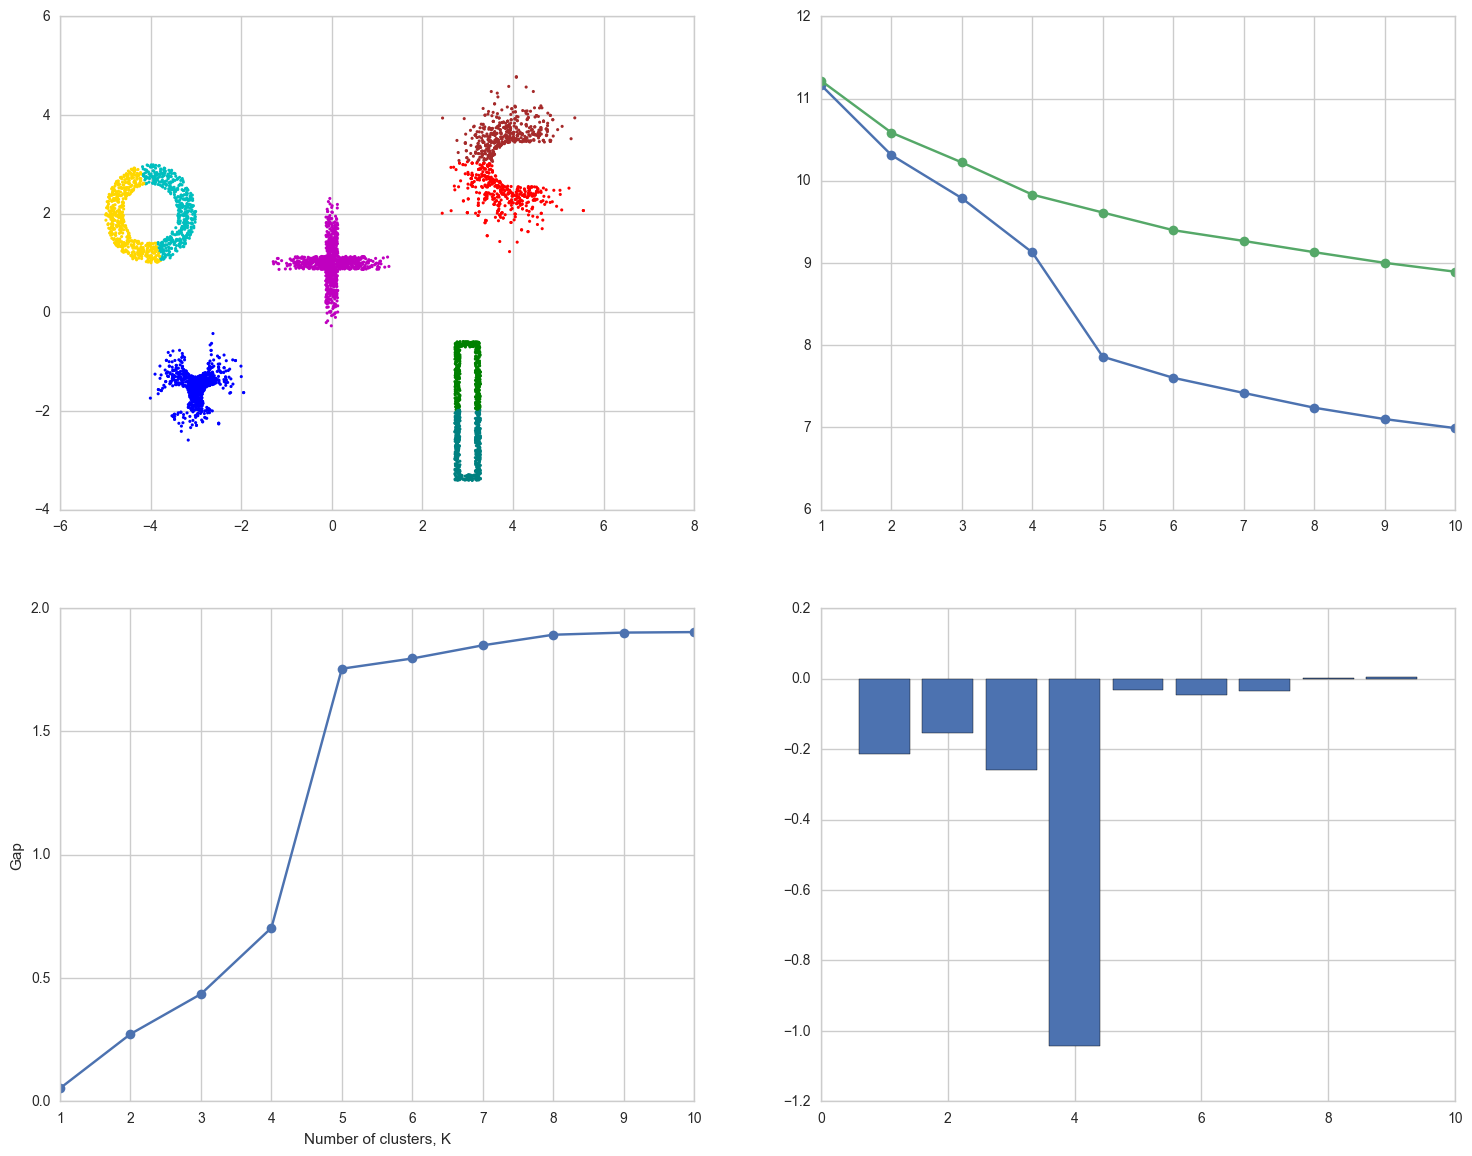

k = 7


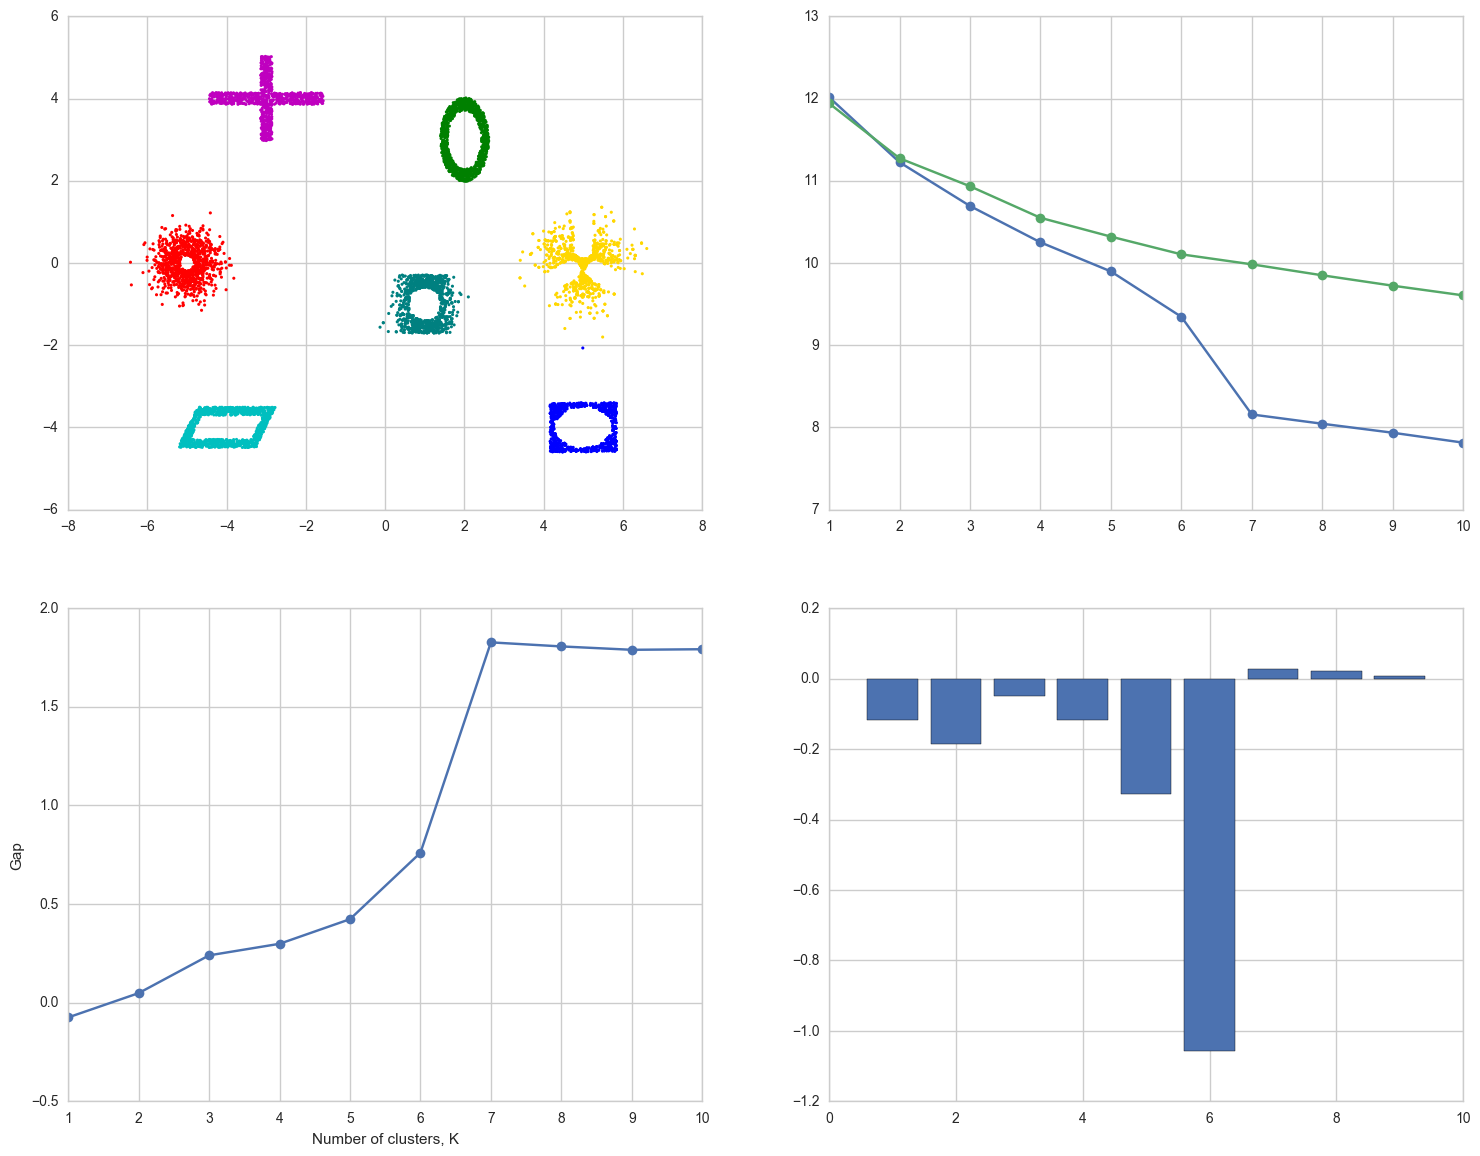

7

In [12]:
def gap(data):
    
    max_k = 10
    B = 10
    
    k_range = np.linspace(1, max_k, num=max_k).astype(int)
    W = np.zeros(max_k)     # Actual Wk
    Wbsum = np.zeros(max_k) # Expected Wk (standardized reference set)
    s = np.zeros(max_k)     # s value
    
    xmin, xmax = min(data[0]), max(data[0])
    ymin, ymax = min(data[1]), max(data[1])
    
    for k in k_range:
        W[k - 1] = np.log(ss(data, k))
        
        Wb = np.zeros(B)
        for i in range(B):
            standard = np.stack((np.random.uniform(xmax, xmin, data.shape[1]),
                                 np.random.uniform(ymax, ymin, data.shape[1])))
            Wb[i] = np.log(ss(standard, k))
            sk = math.sqrt(1 + (1 / B)) * np.std(Wb)
        Wbsum[k - 1] = sum(Wb) / B
        s[k - 1] = sk
    
    gap = Wbsum - W
    indicator = np.array([gap[i] - gap[i + 1] + s[i + 1] for i in range(max_k - 1)])
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
    fig.set_size_inches(18, 14)
    
    ax2.plot(k_range, W, '-o')
    ax2.plot(k_range, Wbsum, '-o')
    
    ax3.plot(k_range, gap, '-o')
    ax3.set_xlabel('Number of clusters, K')
    ax3.set_ylabel('Gap')
    
    ax4.bar(np.delete(k_range, max_k - 1), indicator, align='center')
    
    K = -1
    
    for i in range(len(indicator)):
        if indicator[i] >= 0:
            K = i + 1
            break
        else:
            i += 1
    
    if K == -1:
        print "Error: Could not find K"
        ax1.scatter(data[0], data[1], s=5, edgecolors='none')
        plt.show()
        return K
    
    print "k =", K
    
    Km = KMeans(n_clusters=K).fit(transpose(data))
    
    clist = ['b','g','r','c','m','gold','teal','brown','olive','darkmagenta','fuchsia']
    clist_truncated = clist[0:K]
    
    custom_map = dict(zip(np.unique(Km.labels_), clist_truncated))
    pt_clrs = []
    
    for label in Km.labels_:
        pt_clrs.append(custom_map[label])
        
    for i in range(len(data[0])):
        ax1.scatter(data[0][i], data[1][i], color=pt_clrs[i], s=5, edgecolors='none')
    
    plt.show()
    return K

gap(set32)
gap(set33)

k = 3


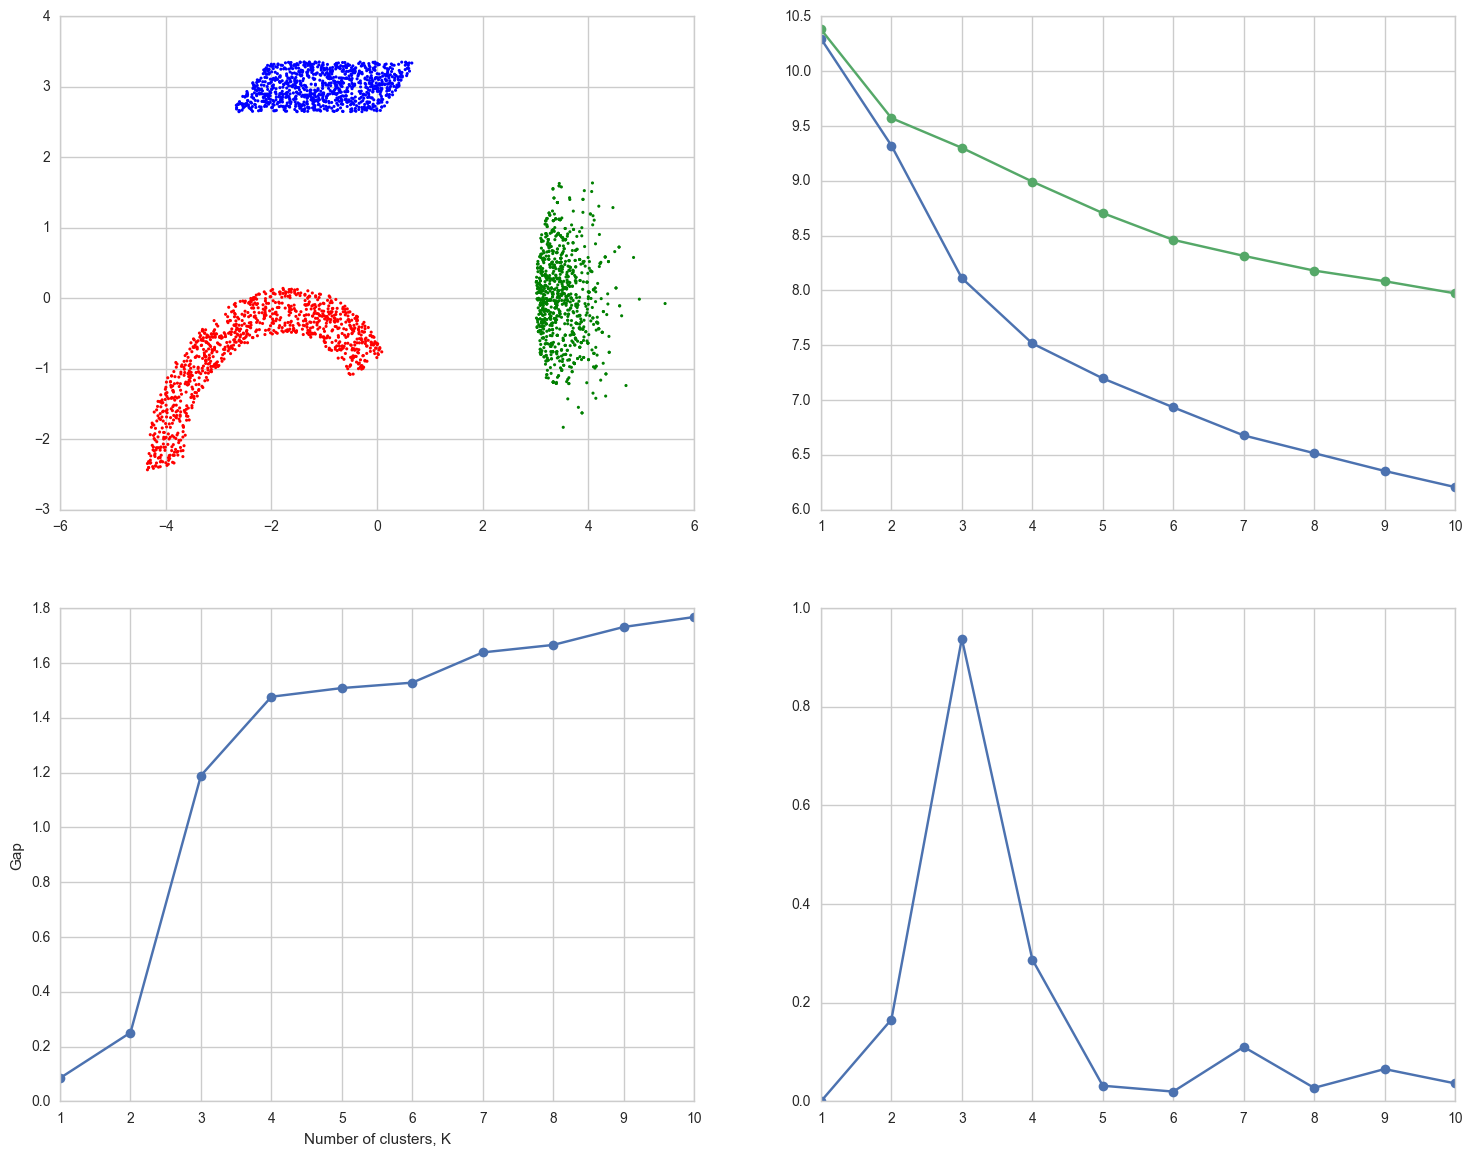

k = 4


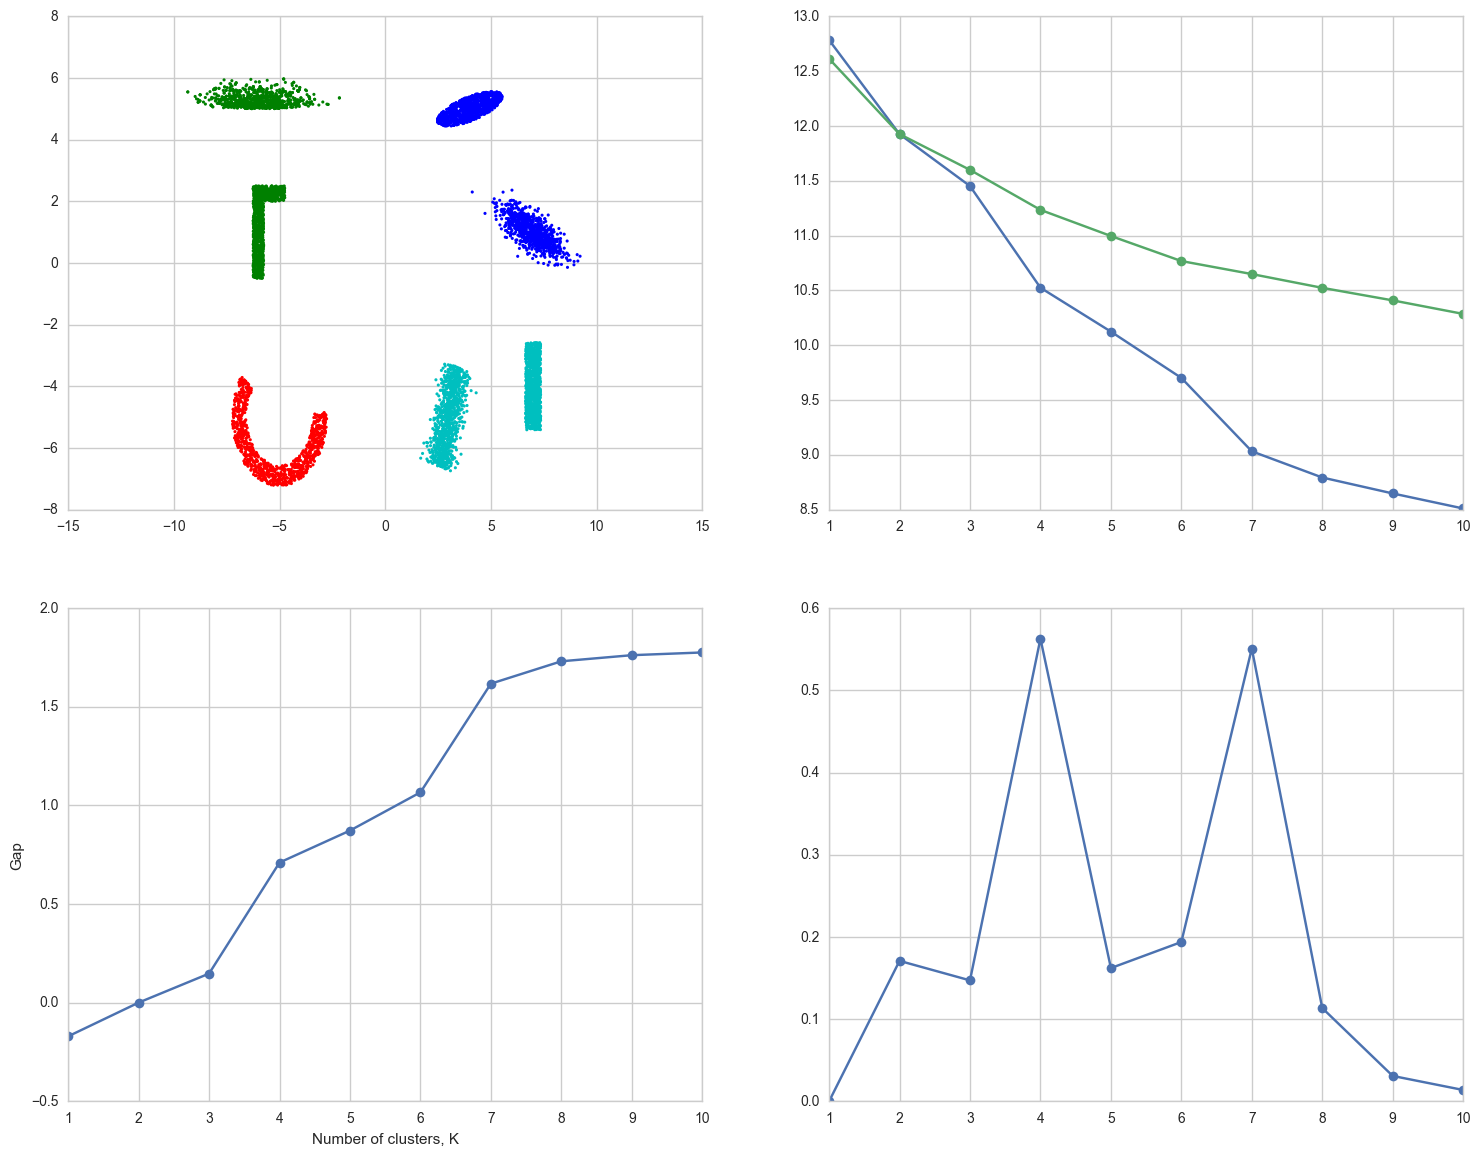

k = 7


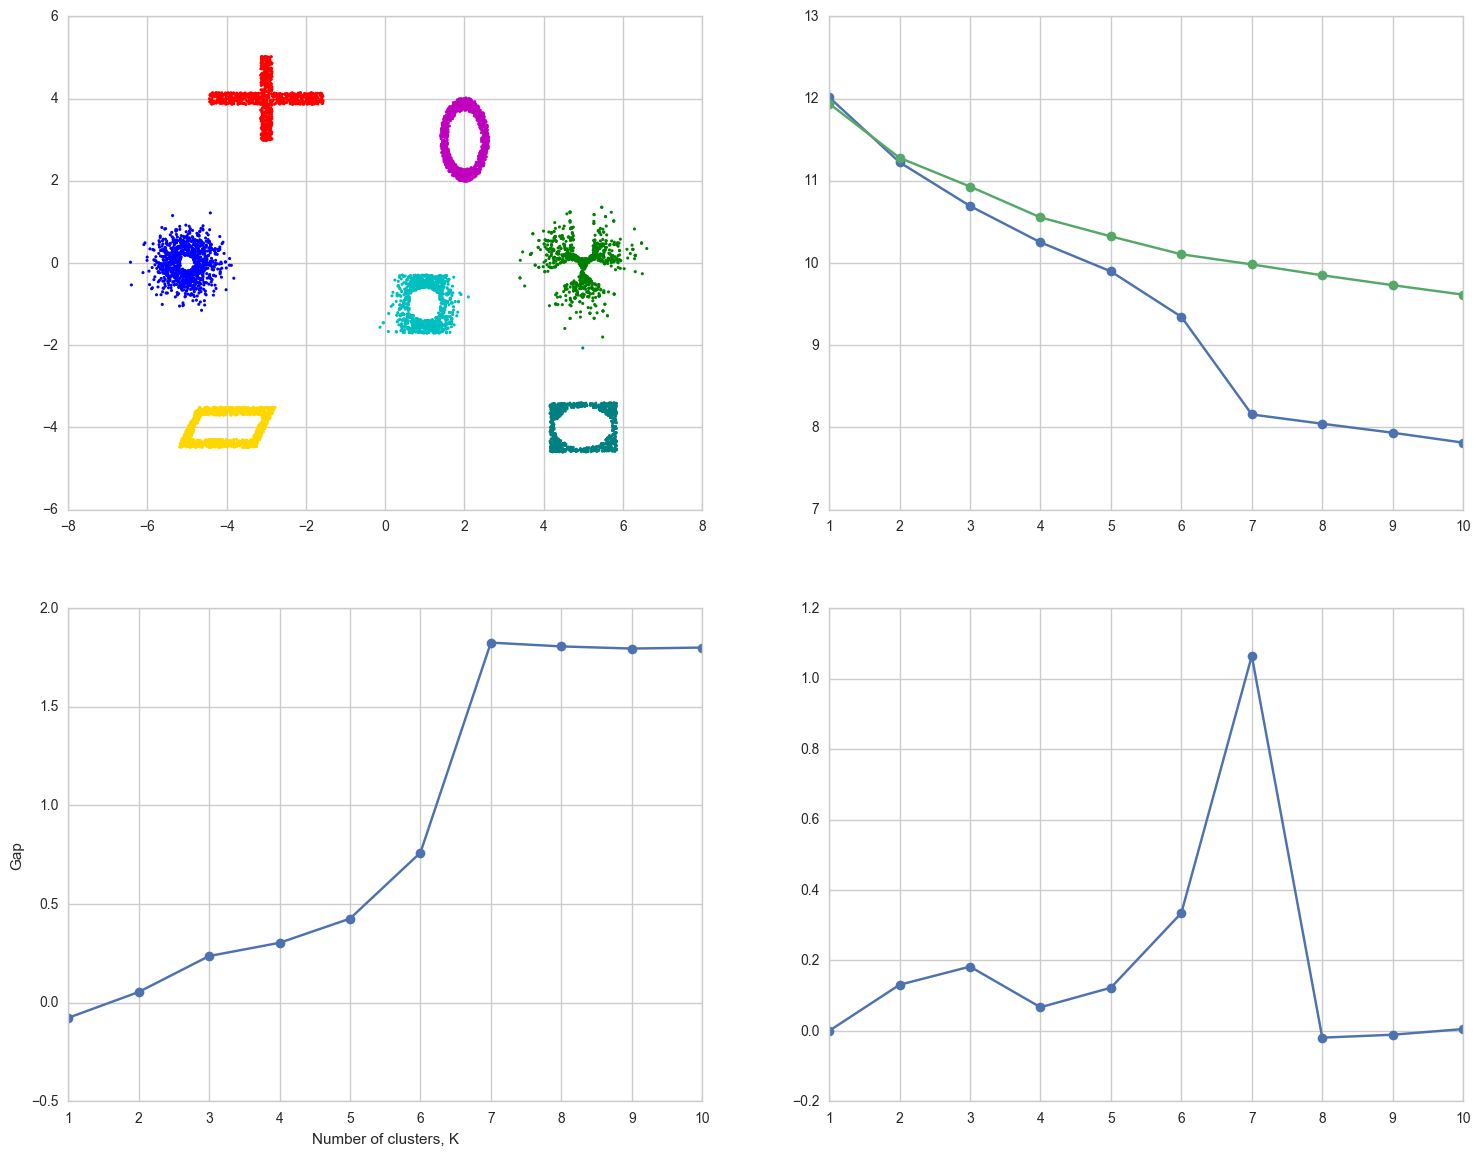

7

In [13]:
def gapmod(data):
    
    max_k = 10
    B = 10
    
    k_range = np.linspace(1, max_k, num=max_k).astype(int)
    W = np.zeros(max_k)     # Actual Wk
    Wbsum = np.zeros(max_k) # Expected Wk (standardized reference set)
    difference = np.zeros(max_k)
    
    xmin, xmax = min(data[0]), max(data[0])
    ymin, ymax = min(data[1]), max(data[1])
    
    for k in k_range:
        W[k - 1] = np.log(ss(data, k))
        
        Wb = np.zeros(B)
        for i in range(B):
            standard = np.stack((np.random.uniform(xmax, xmin, data.shape[1]),
                                 np.random.uniform(ymax, ymin, data.shape[1])))
            Wb[i] = np.log(ss(standard, k))
        Wbsum[k - 1] = sum(Wb) / B
    
    gap = Wbsum - W
    difference = np.insert(np.array([gap[i + 1] - gap[i] for i in range(max_k - 1)]), 0, 0)
    
    K = np.argmax(difference) + 1
    print "k =", K
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
    fig.set_size_inches(18, 14)
    
    ax2.plot(k_range, W, '-o')
    ax2.plot(k_range, Wbsum, '-o')
    
    ax3.plot(k_range, gap, '-o')
    ax3.set_xlabel('Number of clusters, K')
    ax3.set_ylabel('Gap')
    
    ax4.plot(k_range, difference, '-o')
    
    Km = KMeans(n_clusters=K).fit(transpose(data))
    
    clist = ['b','g','r','c','m','gold','teal','brown','olive','darkmagenta','fuchsia']
    clist_truncated = clist[0:K]
    
    custom_map = dict(zip(np.unique(Km.labels_), clist_truncated))
    pt_clrs = []
    
    for label in Km.labels_:
        pt_clrs.append(custom_map[label])
        
    for i in range(len(data[0])):
        ax1.scatter(data[0][i], data[1][i], color=pt_clrs[i], s=5, edgecolors='none')
    
    plt.show()
    return K

gapmod(set21)
gapmod(set23)
gapmod(set33)

### Silhouette Analysis

The silhouette score is a heuristic used on each individual point $P$ measuring how well it has been clustered. It computes the distances between $P$ and every other point in its own cluster, and the distances between $P$ and every point in the nearest neighbouring cluster to give a value from -1 to 1. A score near 1 indicates $P$ has undoubtedly been classified correctly, a score around 0 indicates that the clustering of $P$ has some abiguity, and a score near -1 indicates it is likely that $P$ was classified incorrectly. This method first clusters the points using $k$-means with a range of $k$ values from 2 to 10 and applies silhouette analysis to compute the average silhouette score for each $k$. The optimal $k$ is then identified as the one with the highest average silhouette score.

**TODO:**
- Description in your own words [DONE]
- Remove extra plots below [DONE]

Reference: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

(2, 10000)


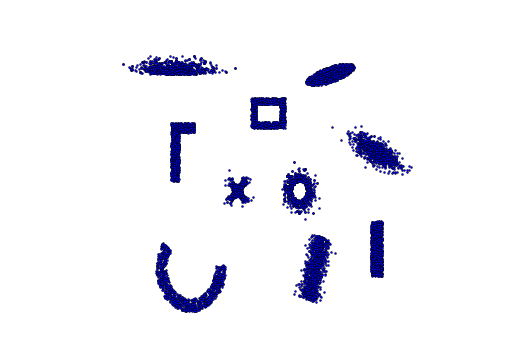

In [14]:
ex = combine(set31, set23)
print ex.shape
plot(ex, '')

k	Average silhouette score
2	0.429507363187
3	0.418140009034
4	0.484218879844
5	0.543244445713
6	0.560459454039
7	0.585814519351
8	0.641272029054
9	0.665011266166
10	0.732085303035
11	0.722561312789
12	0.707874929749
13	0.708034810973
14	0.683865232668
15	0.663241293436



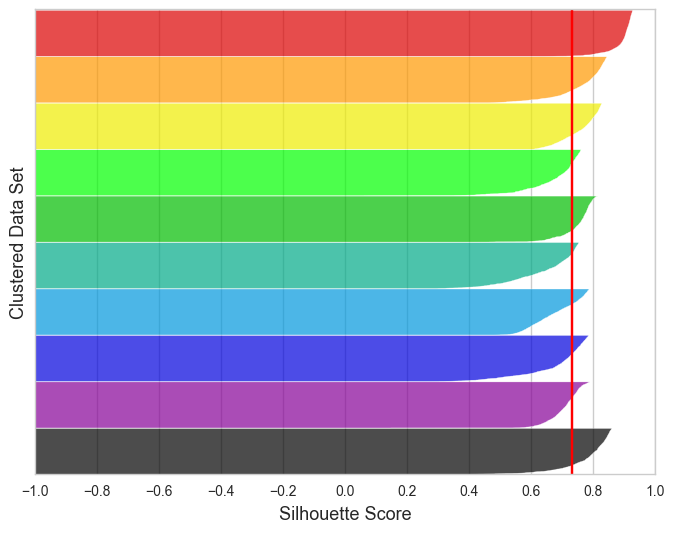

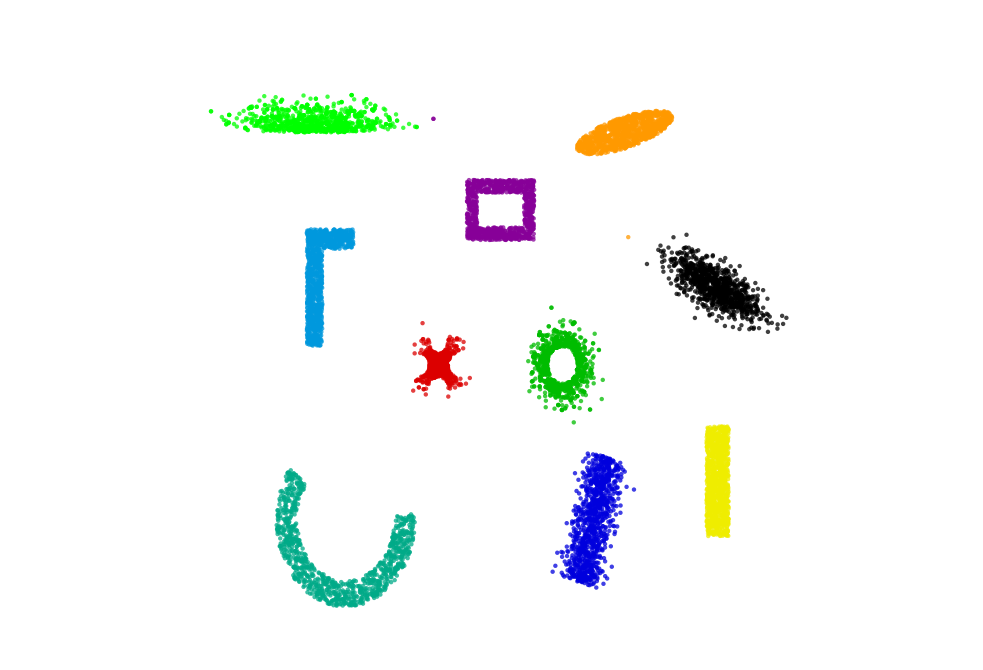

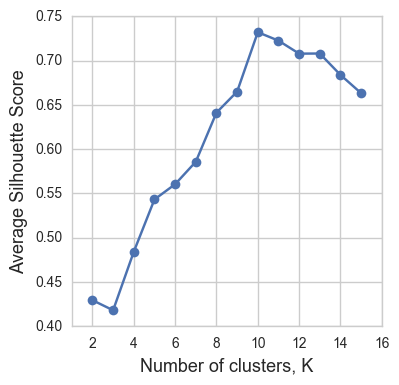

10

In [15]:
def silhouette(data):
    
    max_k = 15
    k_range = np.linspace(2, max_k, num=max_k - 1).astype(int)
    avg_scores = np.stack((k_range,np.zeros(max_k - 1)))

    for k in k_range:

        km = KMeans(n_clusters=k).fit(transpose(data))
        avg_scores[1,k - 2] = silhouette_score(transpose(data), km.labels_)
    
    df = pd.DataFrame(np.transpose(avg_scores), columns = ['k','Average silhouette score'])
    df[list("k")] = df[list("k")].astype(int)

    print df.to_csv(sep='\t', index=False)
    
    k = int(avg_scores[0, np.argmax(avg_scores[1])])
    km = KMeans(n_clusters=k).fit(transpose(data))
    all_values = silhouette_samples(transpose(data), km.labels_)

    gap = 10
    y_lower = gap #lower bound of each cluster on graph
    
    plt.figure(figsize=(8,6))
    ax1 = plt.gca()    
    ax1.set_xlim([-1, 1])
    ax1.set_ylim([0, len(km.labels_) + (k + 1) * gap])
    ax1.set_yticks([])
    ax1.set_xticks([-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    ax1.set_ylabel('Clustered Data Set', fontsize=13)
    ax1.set_xlabel('Silhouette Score', fontsize=13)

    for i in range(k):
            
        #silhouette values for the ith cluster, ordered
        values = all_values[km.labels_ == i]
        values.sort()

        #number of points in ith cluster
        size = len(values)

        #silhouette of each cluster   
        color = cm.spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_lower + size), -1, values, facecolor=color, edgecolor='w', alpha=0.7)

        y_lower += size + gap

    #average line
    ax1.axvline(x=avg_scores[1,k - 2], color="red", linestyle="-")
    plt.show()
    
    colors = cm.spectral(km.labels_.astype(float) / k)
    
    plt.figure(figsize=(12,8))
    plt.scatter(data[0], data[1], marker='o', s=10, lw=0, alpha=0.75, c=colors)
    plt.axis('off')
    plt.show()
    
    plt.figure(figsize=(4,4), dpi=120)
    plt.plot(avg_scores[0], avg_scores[1], '-o')
    plt.ylabel('Average Silhouette Score', fontsize=13)
    plt.xlabel('Number of clusters, K', fontsize=13)
    plt.xlim([1,16])
    plt.show()
    
    return k

silhouette(combine(set31, set23))

### Density-based Clustering (DBSCAN)

#### TODO:
- Use sorted distances to find eps for DBSCAN (assume MinPts=4)
- Explore other methods to find eps and MinPts

In [16]:
d1 = DBSCAN().fit(transpose(testset))
d2 = DBSCAN(eps = 1).fit(transpose(testset))
d3 = DBSCAN(eps = 5).fit(transpose(testset))
plot(testset, 'Unpartitioned')
colplt(testset, d1.labels_, 'DBSCAN, eps not set')
colplt(testset, d2.labels_, 'DBSCAN, eps=0.1')
colplt(testset, d3.labels_, 'DBSCAN, eps=10')

NameError: name 'testset' is not defined

### Future Work (Summer 2017):

- X-Means
- OPTICS
- Voronoi-based methods (StormGraph etc.)
- Neural Networks: Autoencoder
- High-dimensional synthetic dataset